# Retail Store Inventory Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        raise
    return data

# Inspect the dataset
def inspect_data(df):
    print("Dataset Overview:")
    print(df.info())
    print("\nMissing Values Summary:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows:")
    print(df.head())
    return df

file_path = 'retail_store_inventory.csv'
data = load_data(file_path)
data = inspect_data(data)

Data loaded successfully.
Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float6

In [3]:
# Data Preprocessing

# Preprocess the dataset
def preprocess_data(df):
    # Fill missing values
    df['Inventory Level'] = df['Inventory Level'].fillna(0)
    
    # Convert 'Date' to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values(by='Date')

    # Aggregate sales data by date, store, and product
    df = df.groupby(['Date', 'Store ID', 'Product ID']).agg({
        'Units Sold': 'sum',
        'Inventory Level': 'sum',
        'Price': 'mean'
    }).reset_index()
    
    return df

data = preprocess_data(data)
print("\nProcessed Data Overview:")
print(data.info())


Processed Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             73100 non-null  datetime64[ns]
 1   Store ID         73100 non-null  object        
 2   Product ID       73100 non-null  object        
 3   Units Sold       73100 non-null  int64         
 4   Inventory Level  73100 non-null  int64         
 5   Price            73100 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.3+ MB
None


C:\Users\milto\AppData\Local\Temp\ipykernel_468\3718347494.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Date', y='Units Sold', ci=None)


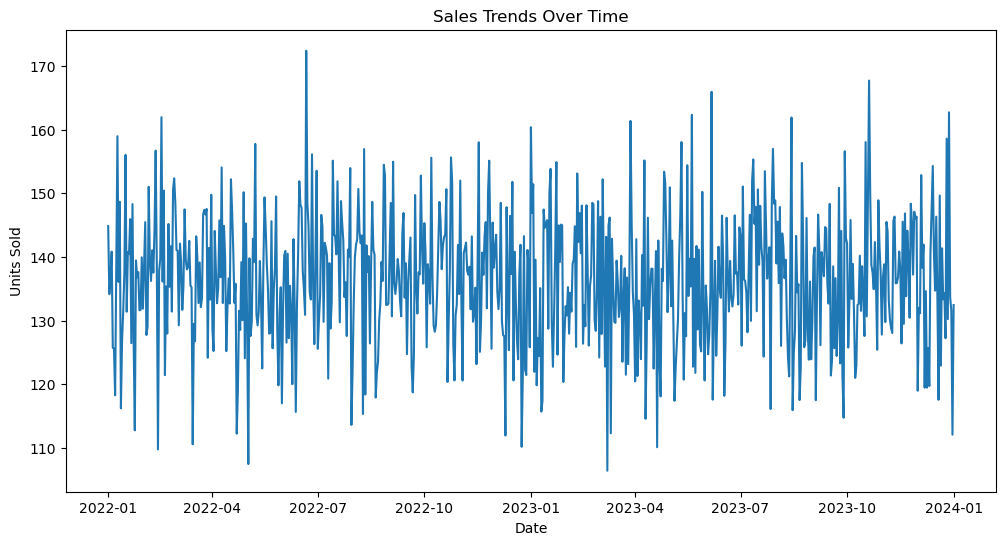

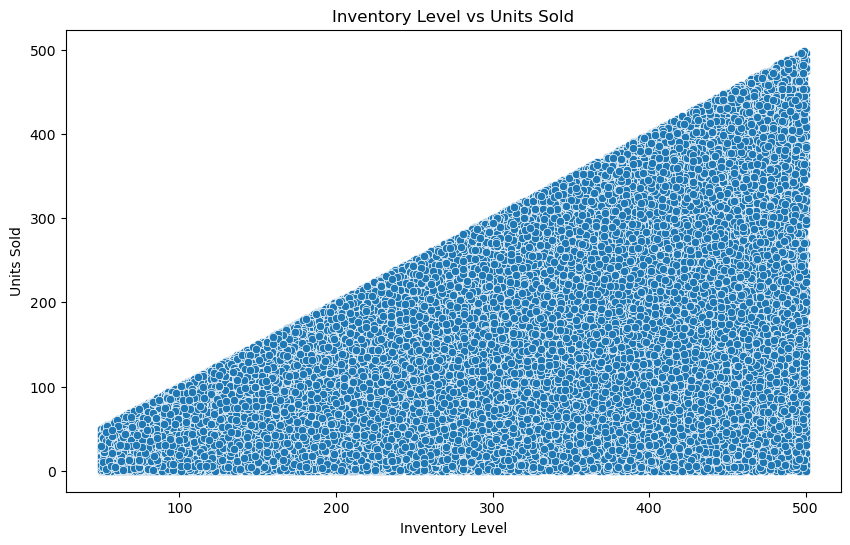

In [4]:
# Exploratory Data Analysis (EDA)

def visualize_data(df):
    # Sales trends over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Date', y='Units Sold', ci=None)
    plt.title('Sales Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.show()

    # Inventory levels vs Units Sold
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Inventory Level', y='Units Sold')
    plt.title('Inventory Level vs Units Sold')
    plt.xlabel('Inventory Level')
    plt.ylabel('Units Sold')
    plt.show()

visualize_data(data)

In [5]:
# Feature Engineering

# Feature Engineering
def create_lag_features(df, lags):
    """Add lag features to the dataset."""
    for lag in lags:
        df[f'Lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(lag)
    return df

def add_rolling_features(df, window_sizes):
    """Add rolling average features to the dataset."""
    for window in window_sizes:
        df[f'Rolling_{window}'] = (
            df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
    return df

def add_seasonal_features(df):
    """Add seasonal features to the dataset."""
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    return df

# Apply feature engineering
data = create_lag_features(data, lags=[1, 7])
data = add_rolling_features(data, window_sizes=[3, 7])
data = add_seasonal_features(data)

# Drop rows with NaN values due to lag/rolling features
data = data.dropna()

print("\nFeature-Engineered Data Overview:")
print(data.info())
print("\nFirst 5 Rows of Feature-Engineered Data:")
print(data.head())


Feature-Engineered Data Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 72400 entries, 700 to 73099
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             72400 non-null  datetime64[ns]
 1   Store ID         72400 non-null  object        
 2   Product ID       72400 non-null  object        
 3   Units Sold       72400 non-null  int64         
 4   Inventory Level  72400 non-null  int64         
 5   Price            72400 non-null  float64       
 6   Lag_1            72400 non-null  float64       
 7   Lag_7            72400 non-null  float64       
 8   Rolling_3        72400 non-null  float64       
 9   Rolling_7        72400 non-null  float64       
 10  Month            72400 non-null  int32         
 11  DayOfWeek        72400 non-null  int32         
 12  IsWeekend        72400 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(2), objec

In [6]:
# Train-Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_test_split_data(df, target_col='Units Sold', scale_features=False):
    """
    Splits the data into training and testing sets, with optional scaling of features.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - target_col: Name of the target column (default: 'Units Sold').
    - scale_features: Whether to scale features using StandardScaler (default: False).
    
    Returns:
    - X_train, X_test, y_train, y_test: Split and optionally scaled datasets.
    """
    # Define feature columns
    features = ['Lag_1', 'Lag_7', 'Inventory Level', 'Price']
    X = df[features]
    y = df[target_col]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Optionally scale features
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Call the function with scaling
X_train, X_test, y_train, y_test = train_test_split_data(data, scale_features=True)

# Output the shapes of training and testing data
print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

# Check the target variable distribution
print("\nTarget Distribution in Training Set:")
print(y_train.describe())
print("\nTarget Distribution in Testing Set:")
print(y_test.describe())



Training Data Shape: (57920, 4)
Testing Data Shape: (14480, 4)

Target Distribution in Training Set:
count    57920.000000
mean       136.490625
std        109.041750
min          0.000000
25%         48.000000
50%        107.000000
75%        203.000000
max        499.000000
Name: Units Sold, dtype: float64

Target Distribution in Testing Set:
count    14480.000000
mean       136.562155
std        108.692649
min          0.000000
25%         49.000000
50%        108.000000
75%        203.000000
max        492.000000
Name: Units Sold, dtype: float64


Epoch 1/50


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1629/1629 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0481 - val_loss: 0.0490
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0480 - val_loss: 0.0490
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0479 - val_loss: 0.0485
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 0.0482 - val_loss: 0.0485
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 0.0482 - val_loss: 0.0485
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0475 - val_loss: 0.0485
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0477 - val_loss: 0.0485
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0481 - val_loss: 0.0486
Epoch 10/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 0.0482 - val_loss: 0.0484
Epoch 11/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 0.0476 - val_loss: 0.0485
Epoch 12/50
1629/16

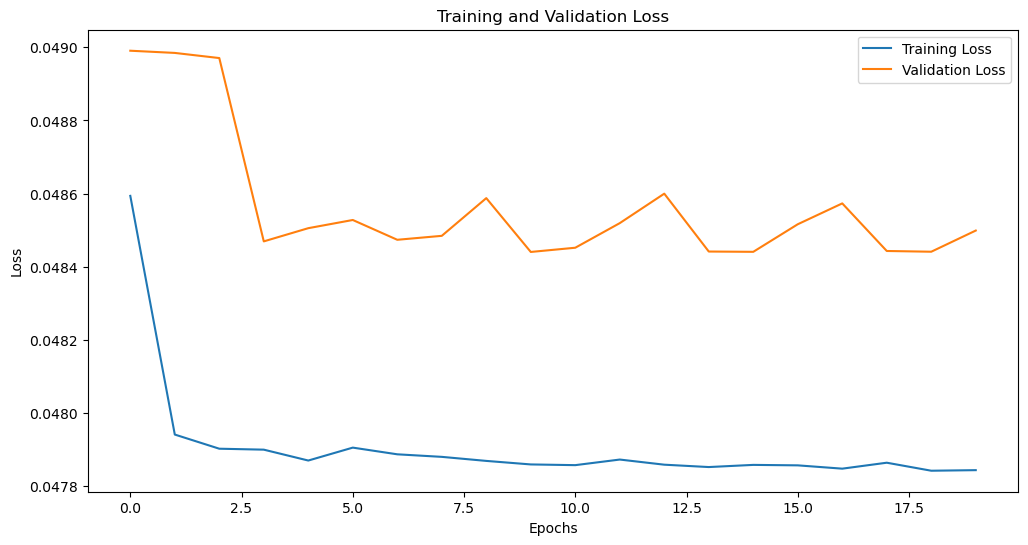

In [7]:
# LSTM Model for Demand Forecasting

# Prepare data for LSTM
def prepare_lstm_data(df, seq_length):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Units Sold', 'Lag_1', 'Lag_7', 'Rolling_3', 'Rolling_7', 'Inventory Level']])
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])
        y.append(scaled_data[i, 0])  # Predicting 'Units Sold'
    return np.array(X), np.array(y), scaler

seq_length = 30
X_lstm, y_lstm, scaler = prepare_lstm_data(data, seq_length)

# Split LSTM data
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Build and train LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = build_lstm_model((seq_length, X_lstm.shape[2]))

# Add early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('lstm_demand_forecasting.h5')

453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
LSTM RMSE: 108.26
LSTM MAE: 89.31


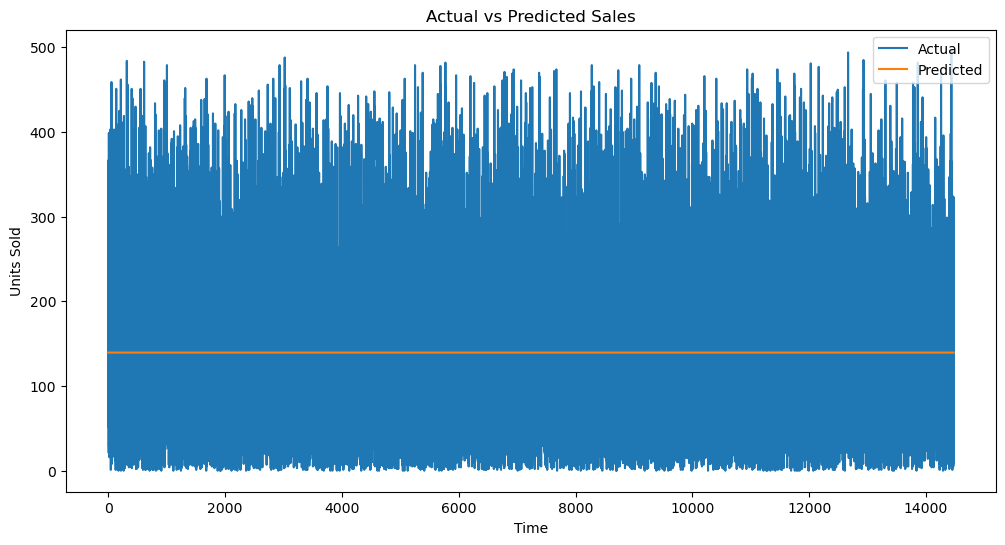

In [8]:
# Model Evaluation and Prediction

# Evaluate and visualize model performance
def evaluate_lstm_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.c_[predictions, np.zeros((len(predictions), X_test.shape[2] - 1))])[:, 0]
    y_test_actual = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), X_test.shape[2] - 1))])[:, 0]

    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    mae = mean_absolute_error(y_test_actual, predictions)
    print(f"LSTM RMSE: {rmse:.2f}")
    print(f"LSTM MAE: {mae:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

evaluate_lstm_model(model, X_test_lstm, y_test_lstm, scaler)
